In [35]:
# import
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time
import scipy.io
from scipy import interpolate
from commands import getoutput as cmd
import scipy.optimize
import shutil
import scipy as sp
from  scipy.ndimage.filters import gaussian_filter
import os
import matplotlib.gridspec as gridspec
import pandas as pd
import cmocean
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
def myfloat(b):
    
    try: 
        b = float(b)
    except ValueError:        
        b = [b for b in b.split('-') if b]
        b = float(b[0])*10**(-float(b[1]))
    return b


In [36]:
%matplotlib inline

In [25]:
def pretty_axes(titlestr, figsize = (8, 4.25)):
    fig = plt.figure(figsize = figsize)
    gs = gridspec.GridSpec(5, 1)
    ax = plt.subplot(gs[0:4, :])
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.12)
    ax.annotate('', xy=(-.15, -0.22), xycoords='axes fraction', xytext=(1.1, -0.22), 
            arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    return fig



In [26]:

def get_Sf_manning(hdum, vdum, xnvdum =0.09 ):

    Sf_manning = vdum**2./hdum**(4./3)*xnvdum**2
    return Sf_manning

def get_Sf_array(vdum):
    pveg = .3
    Dveg = 8e-3
    Rv = Dveg*(1-pveg)/pveg*np.pi/4
    Rev = vdum*Rv/1e-6
    Cdarray = 50*Rev**(-0.43) + 0.7*(1-np.exp(-Rev/15000.))
    m = 4*pveg/np.pi/Dveg**2
    Sf_array = Cdarray*m*Dveg/(1-pveg)*vdum**2/2/9.8
    return Sf_array

def get_Sf_poggi(hdum, vdum):
    LAI = 1.0
    kv = 0.4
    Hc = 0.10
    Cd = 0.20
    betadum = np.min(0.13470*np.sqrt(LAI/Hc), 0.330)
    lc = Hc/Cd/LAI
    leff = 2.0*betadum**3.0*lc

    Rdo = 1.-(2.*betadum**3.0/kv)*(1/Cd/LAI)
    Rzo = (1.-Rdo)*np.exp(kv/betadum)

    RdoH = Rdo*Hc
    RzoH = Rzo*Hc

    Uavg = 1/hdum*(leff/betadum**2)*np.exp(-betadum*Hc/leff)*(np.exp(betadum*hdum/leff)-1)
    #   Rel = vmag*depth/1.e-6

    sqrtffact = 1.0/Uavg

    ffact = 8*sqrtffact**2
    Sf_poggi = ffact*vdum*vdum/8./9.8/hdum
    return Sf_poggi



In [27]:
def get_Sf_pois(hdum, vdum):
    Sf_pois = 3.0*1e-6*vdum/hdum**(2.0)/9.8     

    return Sf_pois

def get_Sf_17(hdum, vdum):
    Re = vdum*hdum/1e-6
    z0 = 0.002
    ffact = 8*(0.18**2)*(z0/(hdum+0.0020))**(2./7)


    Sf_17 =ffact*vdum*vdum/8./9.8/hdum
    

    return Sf_17

In [28]:
hdum = np.arange(0.002, .008, .0005)
vdum = np.arange(0.002, .08, .005)
hdum,vdum = np.meshgrid(hdum, vdum)

vdum = vdum.flatten()
hdum = hdum.flatten()

Re = vdum*hdum/1e-6
Sf_poggi = get_Sf_poggi(hdum, vdum )
Sf_array = get_Sf_array( vdum )
Sf_manning = get_Sf_manning(hdum, vdum )

Sf_17 = get_Sf_17(hdum, vdum )
Sf_manning_bare = get_Sf_manning(hdum, vdum, xnvdum= 0.02 )
Sf_pois = get_Sf_pois(hdum, vdum)


In [29]:
dff = pd.DataFrame({'h': hdum, 'v':vdum, 'Re' : Re, 'Sf_array': Sf_array,
                    'Sf_poggi': Sf_poggi,
                    'Sf_manning': Sf_manning,
                    'Sf_manning_bare': Sf_manning_bare,
                    'Sf_17': Sf_17,  
                    'Sf_pois': Sf_pois,                      
                       })

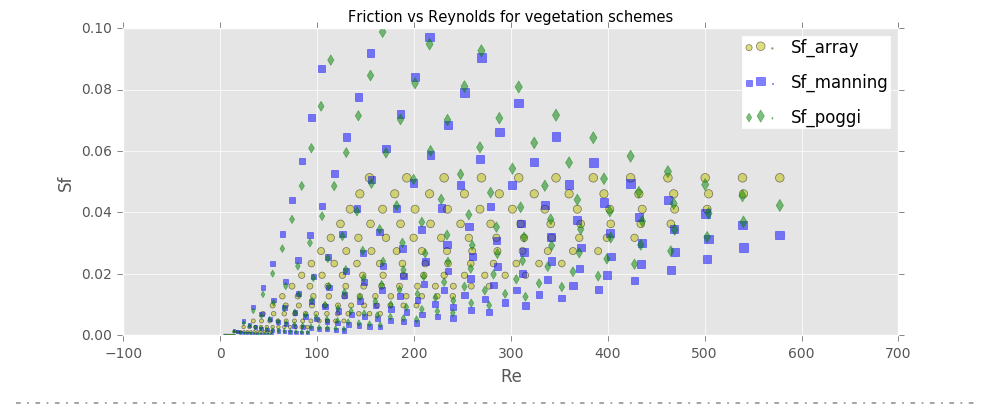

In [30]:
## veg plots
fig = pretty_axes('', figsize  = (10,5))

plt.scatter(dff.Re, dff.Sf_array, alpha = .5, linewidth = .5,
             c = 'y', marker = 'o', s = dff.v*5e2, edgecolors='k',
            cmap="viridis_r")
plt.scatter(dff.Re, dff.Sf_manning,    alpha = .5, edgecolors='b', linewidth = .5,
             c= 'b', marker = 's', s = dff.v*5e2, cmap="viridis_r")
plt.scatter(dff.Re, dff.Sf_poggi,    alpha = .5, edgecolors='g', linewidth = .5,
             c = 'g', marker = 'd', s = dff.v*5e2, cmap="viridis_r")

plt.title('Friction vs Reynolds for vegetation schemes', fontsize = 10.5)
plt.xlabel("Re")
plt.ylabel("Sf")
ax = plt.gca()
ax.set_ylim(0, 0.1);
#ax.set_xlim(-10, 500)
markers = ['o','s']
# for pw in markers:
#     plt.scatter([], [], s=100, c="k",label=str(pw))

hh, l = plt.gca().get_legend_handles_labels()
legend = plt.legend(hh[:], l[:], labelspacing=1.,  borderpad=.1, #title = 'friction',
             frameon=True, framealpha=1.,loc = 'best')
legend.get_frame().set_facecolor('w')


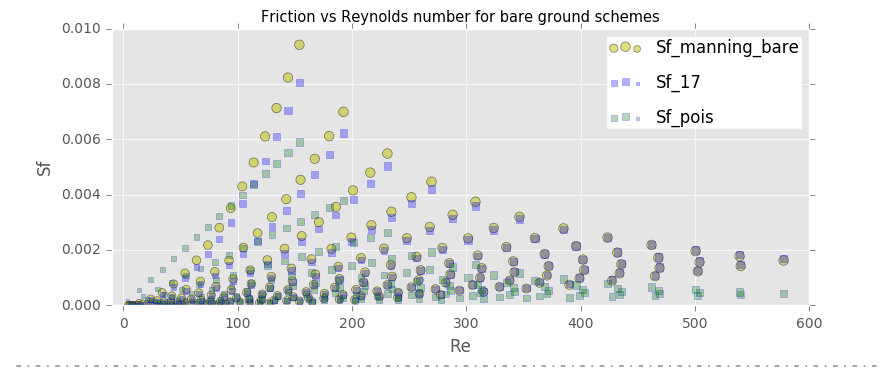

In [31]:
fig = pretty_axes('', figsize  = (9,4.5))

markersize =  np.sqrt(dff.v)*1e2
plt.scatter(dff.Re, dff.Sf_manning_bare, alpha = .5, linewidth = .5,
             c = 'y', marker = 'o', s = markersize+20, edgecolors='k',
            cmap="viridis_r")
plt.scatter(dff.Re, dff.Sf_17,    alpha = .3, edgecolors='b', linewidth = .5,
             c= 'b', marker = 's', s = markersize, cmap="viridis_r")

plt.scatter(dff.Re, dff.Sf_pois,    alpha = .3, edgecolors='b', linewidth = .5,
             c= 'g', marker = 's', s = markersize, cmap="viridis_r")

plt.title('Friction vs Reynolds number for bare ground schemes', fontsize = 10.5)
plt.xlabel("Re")
plt.ylabel("Sf")
ax = plt.gca()
ax.set_ylim(0, 0.01);
ax.set_xlim(-10, 600)
markers = ['o','s']

# for pw in markers:
#     plt.scatter([], [], s=100, c="k",label=str(pw))
# ax.set_yscale("symlog")


hh, l = plt.gca().get_legend_handles_labels()
legend = plt.legend(hh[:], l[:], labelspacing=1.,  borderpad=.1, #title = 'friction',
             frameon=True, framealpha=1.,loc = 'best')
legend.get_frame().set_facecolor('w')


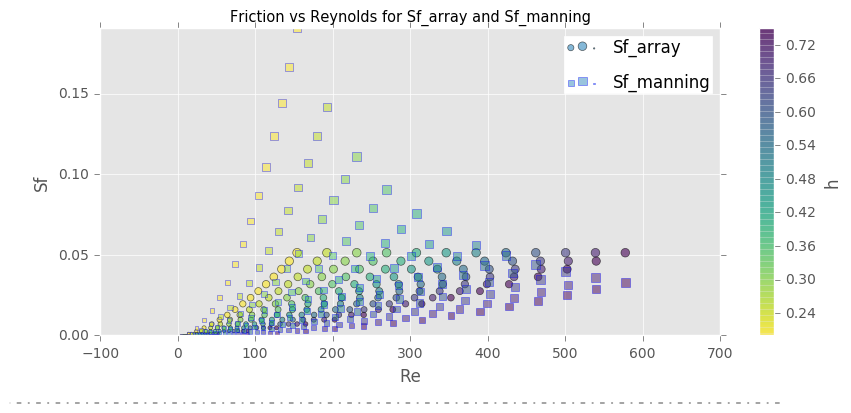

In [32]:
# bare soil difference
fig = pretty_axes('', figsize  = (10,5))

# fld1 = 'Sf_poggi'
fld1 = 'Sf_array'
fld2 = 'Sf_manning'
#fld1 =  'Sf_17'
# fld2 = 'Sf_manning_bare'
mstyles = {'Sf_array' : 'o', 'Sf_manning': 's', 
           'Sf_manning_bare': 's', 'Sf_17': 'd', 
           'Sf_poggi' : 'd', 'Sf_pois': 'v'}

plt.title('Friction vs Reynolds for {0} and {1}'.format(fld1, fld2), fontsize = 10.5)
plt.scatter(dff.Re, dff[fld1], alpha = .6, linewidth = .5,
             c = dff.h*100, marker = mstyles[fld1], s = dff.v*5e2, edgecolors='k',
            cmap="viridis_r")
plt.scatter(dff.Re, dff[fld2],    alpha = .5, edgecolors='b', linewidth = .5,
             c = dff.h*100, marker =  mstyles[fld2], s = dff.v*5e2, cmap="viridis_r")

plt.colorbar(label="h")
plt.xlabel("Re")
plt.ylabel("Sf")
ax = plt.gca()
ymax = max(np.max( dff[fld2]), np.max(dff[fld1])); ax.set_ylim(0, ymax)
markers = ['o','s']

h, l = plt.gca().get_legend_handles_labels()
legend = plt.legend(h[:], l[:], labelspacing=1.,  borderpad=.1, #title = 'friction',
             frameon=True, framealpha=1.,loc = 'best')
legend.get_frame().set_facecolor('w')


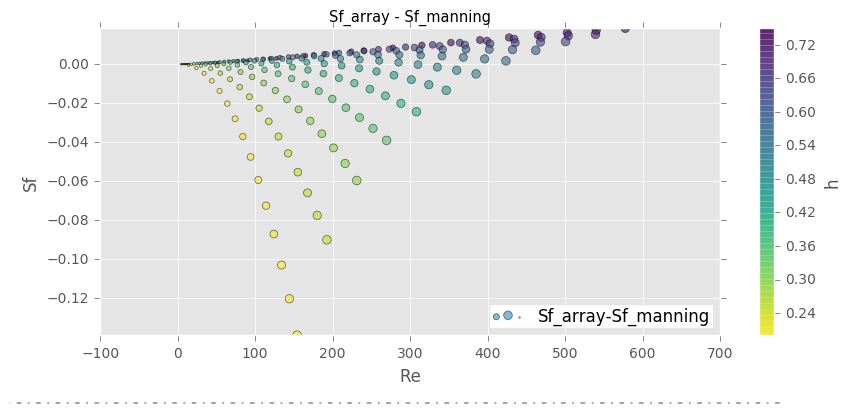

In [34]:

plotname = 'Sf_array-Sf_manning'
# plotname = 'Sf_poggi-Sf_manning'
#plotname = 'Sf_pois-Sf_manning_bare'
# plotname = 'Sf_17-Sf_manning_bare'
dff[plotname] = dff[plotname.split('-')[0]] - dff[plotname.split('-')[1]]
fig = pretty_axes('', figsize  = (10,5))

plt.title(' - '.join(plotname.split('-')), fontsize = 10.5)

plt.scatter(dff.Re, dff[plotname], alpha = .6, linewidth = .5,
             c = dff.h*100, marker = 'o', s = dff.v*5e2, edgecolors='k',
            cmap="viridis_r")

plt.colorbar(label="h")
plt.xlabel("Re")
plt.ylabel("Sf")
ax = plt.gca()
ymax= np.max(dff[plotname.split('-')[0]] - dff[plotname.split('-')[1]])
ymin = np.min(dff[plotname.split('-')[0]] - dff[plotname.split('-')[1]])
ax.set_ylim(ymin- 1e-4, ymax+1e-4)
markers = ['o','s']

h, l = plt.gca().get_legend_handles_labels()
legend = plt.legend(h[:], l[:], labelspacing=1.,  borderpad=.1, #title = 'friction',
             frameon=True, framealpha=1.,loc = 'lower right')
legend.get_frame().set_facecolor('w')
